In [39]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import pandas as pd
import os
from tqdm.auto import tqdm

tqdm.pandas()

# params

In [87]:
dataset_location = "gs://mlteam-ml-specialization-2021-blackfriday/dataset/raw/"
trainset = os.path.join(dataset_location, "train.csv") 
testset = os.path.join(dataset_location, "test.csv") 
model_location = "gs://mlteam-ml-specialization-2021-blackfriday/aiplatform_jobs/bf_20210513_110816/2/2/Scann"
k_min = 10

# baseline

In [8]:
class BlackFridayBaseline:
    def __init__(self, trainset_location, user_features_list, build_inplace=False):
        self.trainset_location, self.user_features_list = trainset_location, user_features_list
        if build_inplace:
            self.build()
        
    def build(self):
        self.df = pd.read_csv(self.trainset_location).groupby(
            user_features+["Product_ID"])["User_ID"].count().reset_index().rename(
            columns={"User_ID":"count_product"})
        
    def predict(self, user_features, n_products):
        mask = None
        for k,v in user_features.items():
            if mask is None:
                mask = self.df[k]==v
            else:
                mask = mask&(self.df[k]==v)
        return self.df[mask].sort_values(self.user_features_list+["count_product"])["Product_ID"].values[:n_products]
        

In [9]:
user_features = [
    "Gender",
    "Age",
    "Occupation",
    "City_Category",
    "Stay_In_Current_City_Years",
    "Marital_Status"
    ]

In [10]:
# test
BlackFridayBaseline(trainset, user_features, True).predict(
    {'Gender': 'F',
     'Age': '0-17',
     'Occupation': 0,
     'City_Category': 'A',
     'Stay_In_Current_City_Years': '2',
     'Marital_Status': 0}, 
    10)

array(['P00034742', 'P00035542', 'P00048742', 'P00057542', 'P00058242',
       'P00102642', 'P00129542', 'P00137242', 'P00145042', 'P00154642'],
      dtype=object)

# model

In [14]:
model = tf.keras.models.load_model(model_location)
model

In [25]:
class PredictionModel:
    def __init__(self, model_path, build_inplace=False):
        self.odel_path=model_path
        if build_inplace:
            self.build()
    
    def build(self):
        self.model=tf.keras.models.load_model(model_location)
        
    def predict_batch(self, model_input):
        scores, products = self.model({k:tf.constant(v) for k,v in model_input.items()})
        return products.numpy()
    
    def predict_single(self, model_input):
        scores, products = self.model({k:tf.constant([v]) for k,v in model_input.items()})
        return products.numpy()

In [26]:
PredictionModel(model_location, True).predict_single({k: str(v) for k,v in 
    {'Gender': 'F',
     'Age': '0-17',
     'Occupation': 0,
     'City_Category': 'A',
     'Stay_In_Current_City_Years': '2',
     'Marital_Status': 0}.items()})

array([[b'P00137142', b'P00265142', b'P00293742', b'P00248742',
        b'P00178342', b'P00183542', b'P00337642', b'P00339042',
        b'P00214842', b'P00087342']], dtype=object)

# ground truth

In [32]:
df=pd.read_csv(testset).groupby(user_features)["Product_ID"].apply(list).reset_index()

In [33]:
df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_ID
0,F,0-17,0,A,2,0,"[P00145442, P00240142, P00057342, P00249742]"
1,F,0-17,0,B,1,0,"[P00085642, P00252642, P00119542, P00294242, P..."
2,F,0-17,0,B,3,0,"[P00057742, P00309942, P00118342, P00025442, P..."
3,F,0-17,0,C,0,0,"[P00251442, P00025642, P00006042, P00327542, P..."
4,F,0-17,0,C,1,0,"[P00325742, P00294542, P00178242, P0096842, P0..."
...,...,...,...,...,...,...,...
2425,M,55+,20,C,0,1,"[P00194242, P00280442, P00232242, P00161542, P..."
2426,M,55+,20,C,1,0,"[P00368342, P00357642, P00087342, P00339042, P..."
2427,M,55+,20,C,1,1,"[P00207942, P00042742, P00187842, P00120042, P..."
2428,M,55+,20,C,2,1,"[P00021942, P00291042, P00294142, P00297042, P..."


In [34]:
baseline = BlackFridayBaseline(trainset, user_features, True)

In [41]:
df["baseline"]=df[user_features].progress_apply(lambda x: baseline.predict(x, k_min), axis=1)

  0%|          | 0/2430 [00:00<?, ?it/s]

In [42]:
model = PredictionModel(model_location, True)

In [64]:
df["predictions"]=df[user_features].progress_apply(lambda x: model.predict_single({k:str(v) for k,v in x.items()})[0].astype(str), axis=1)

  0%|          | 0/2430 [00:00<?, ?it/s]

In [65]:
df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_ID,baseline,predictions
0,F,0-17,0,A,2,0,"[P00145442, P00240142, P00057342, P00249742]","[P00034742, P00035542, P00048742, P00057542, P...","[P00137142, P00265142, P00293742, P00248742, P..."
1,F,0-17,0,B,1,0,"[P00085642, P00252642, P00119542, P00294242, P...","[P00000142, P00003442, P00003642, P00003942, P...","[P00146242, P00238142, P0096642, P00370642, P0..."
2,F,0-17,0,B,3,0,"[P00057742, P00309942, P00118342, P00025442, P...","[P00001042, P00001142, P00002942, P00004442, P...","[P00238142, P00137142, P00310342, P00187942, P..."
3,F,0-17,0,C,0,0,"[P00251442, P00025642, P00006042, P00327542, P...","[P00000242, P00000842, P00001342, P00002742, P...","[P00238142, P00187942, P00146242, P00104842, P..."
4,F,0-17,0,C,1,0,"[P00325742, P00294542, P00178242, P0096842, P0...","[P00000242, P00000442, P00000742, P00003442, P...","[P00238142, P00370642, P00146242, P00358742, P..."
...,...,...,...,...,...,...,...,...,...
2425,M,55+,20,C,0,1,"[P00194242, P00280442, P00232242, P00161542, P...","[P00005942, P00024742, P00155442, P00161142, P...","[P00354742, P00313642, P00256042, P00271242, P..."
2426,M,55+,20,C,1,0,"[P00368342, P00357642, P00087342, P00339042, P...","[P00046742, P00083842, P00085042, P00087642, P...","[P00354742, P00311542, P00158042, P00116542, P..."
2427,M,55+,20,C,1,1,"[P00207942, P00042742, P00187842, P00120042, P...","[P00000642, P00001742, P00002542, P00010742, P...","[P00354742, P00158042, P00311542, P00331842, P..."
2428,M,55+,20,C,2,1,"[P00021942, P00291042, P00294142, P00297042, P...","[P00001642, P00005042, P00015642, P00016542, P...","[P00275642, P00158042, P00273442, P00116542, P..."


In [97]:
df_orig=df
df=df_orig[df_orig["Product_ID"].apply(len) >= k_min]
df_metrics = pd.DataFrame(index=df.index)
df_metrics["baseline_precision"]=df[["Product_ID","baseline"]].progress_apply(lambda x: np.intersect1d(x["Product_ID"],x["baseline"]).shape[0]/k_min,axis=1)
df_metrics["predictions_precision"]=df[["Product_ID","predictions"]].progress_apply(lambda x: np.intersect1d(x["Product_ID"],x["predictions"]).shape[0]/k_min,axis=1)

  0%|          | 0/2147 [00:00<?, ?it/s]

  0%|          | 0/2147 [00:00<?, ?it/s]

<AxesSubplot:>

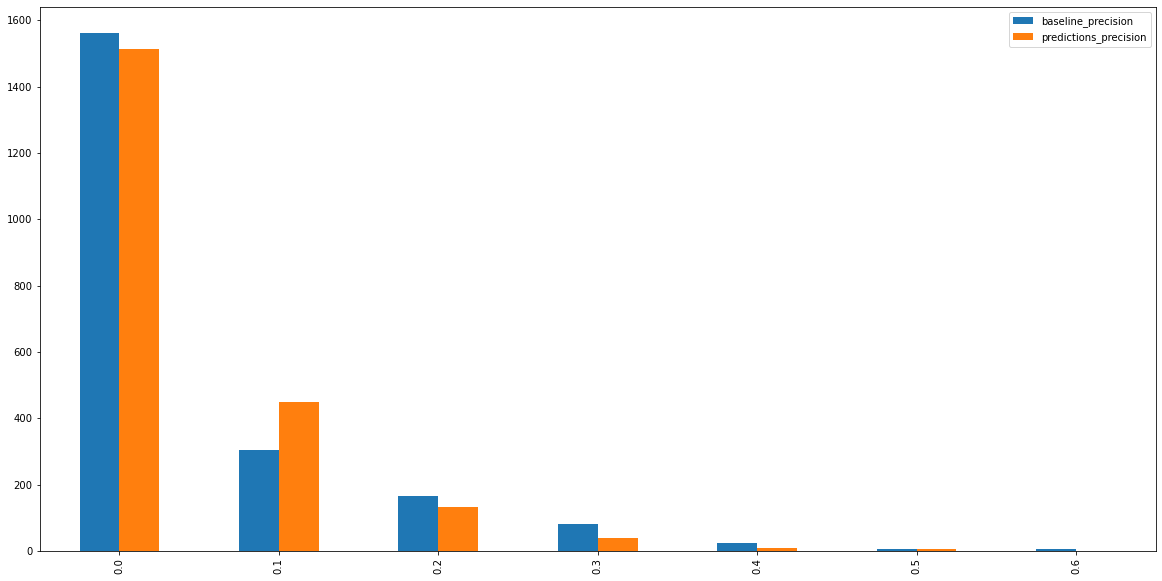

In [116]:
pd.DataFrame([
    df_metrics["baseline_precision"].apply(lambda x: round(x,2)).value_counts(),
    df_metrics["predictions_precision"].apply(lambda x: round(x,2)).value_counts()
]).transpose().fillna(0).plot.bar(figsize=(20,10))

In [118]:
df_metrics[["baseline_precision","predictions_precision"]].mean()

baseline_precision       0.048067
predictions_precision    0.041593
dtype: float64